In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import time
import os

In [2]:
# ======================
# Dataset Loader
# ======================
IMG_SIZE = (224, 224)   # ubah ke 224x224
BATCH_SIZE = 32          # ubah batch size
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset_classification")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'valid'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_dataset.class_names
num_classes = len(class_names)

print("Kelas terdeteksi:", class_names)

for ds, name in zip([train_dataset, val_dataset, test_dataset], ['Train','Valid','Test']):
    counts = {c:0 for c in class_names}
    for _, labels in ds:
        labels_idx = np.argmax(labels.numpy(), axis=1)
        for idx in labels_idx:
            counts[class_names[idx]] += 1
    print(f"{name} dataset counts:", counts)


Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Kelas terdeteksi: ['Ganoderma', 'Sehat']
Train dataset counts: {'Ganoderma': 600, 'Sehat': 387}
Valid dataset counts: {'Ganoderma': 63, 'Sehat': 41}
Test dataset counts: {'Ganoderma': 26, 'Sehat': 16}


In [3]:
# ======================
# Build CNN Custom
# ======================
def build_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# ======================
# Training
# ======================
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)
model.save("model_ganoderma_cnn.h5")

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5161 - loss: 251.2824 - val_accuracy: 0.6442 - val_loss: 0.6878
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6693 - loss: 0.6338 - val_accuracy: 0.6731 - val_loss: 0.6570
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7506 - loss: 0.5110 - val_accuracy: 0.6154 - val_loss: 0.7024
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8250 - loss: 0.4308 - val_accuracy: 0.5673 - val_loss: 0.7540
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8754 - loss: 0.3352 - val_accuracy: 0.5192 - val_loss: 0.8639
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9021 - loss: 0.2836 - val_accuracy: 0.5865 - val_loss: 0.9832
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8264 - loss: 0.4636 - val_accuracy: 0.5288 - val_loss: 0.9725
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8804 - loss: 0.2712 - val_accuracy: 0.6058 - val_los

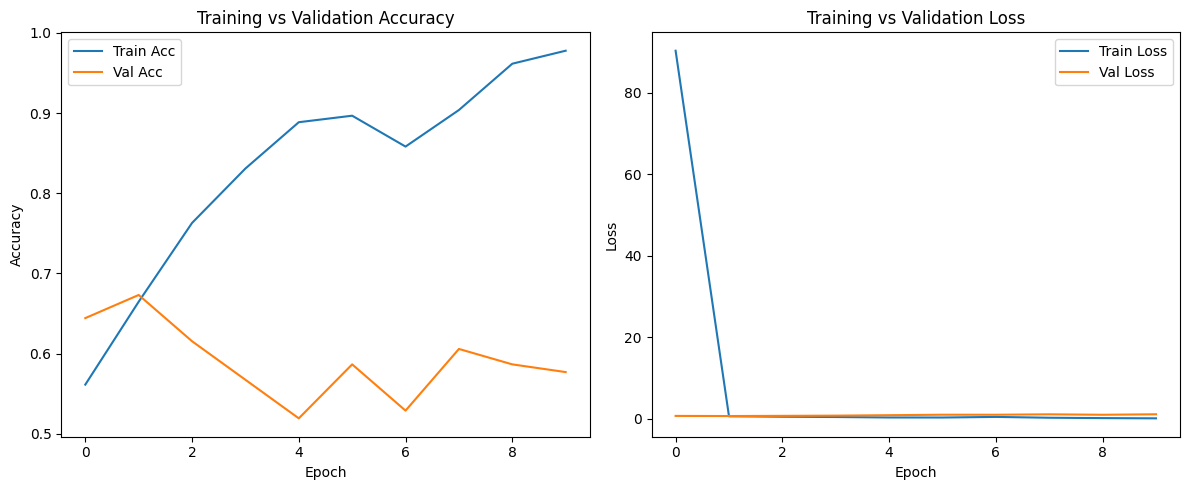

In [5]:
# ======================
# Visualisasi Kurva Training
# ======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# ======================
# Evaluasi di Test Dataset
# ======================
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

y_true, y_pred, y_prob = [], [], []
start_time = time.time()
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if num_classes == 2:
        # binary: pastikan y_prob_arr 2 kolom
        if preds.shape[1] == 1:
            preds = np.hstack([1 - preds, preds])
        y_prob.extend(preds[:, 1])
    else:
        y_prob.extend(preds)  # multi-class: simpan semua probs
end_time = time.time()
inference_time = (end_time - start_time) / len(y_true)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.6156 - loss: 1.0662

Test Accuracy: 0.5952 | Test Loss: 1.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


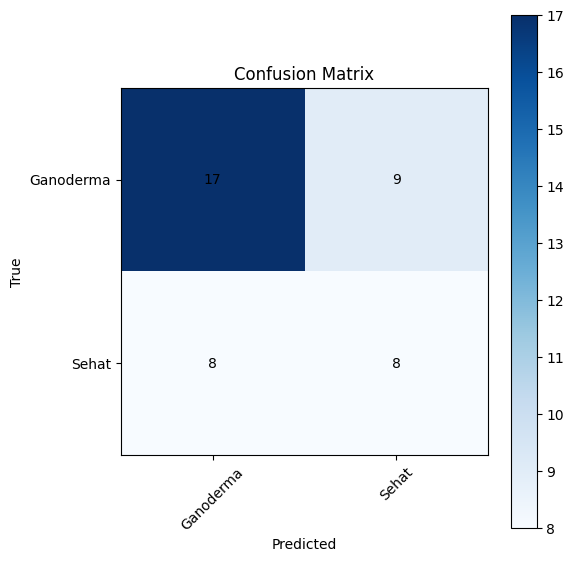

In [7]:
# ======================
# Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
# ======================
# Classification Report
# ======================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)


print(f"Accuracy: {acc:.4f} | Precision(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1(macro): {f1:.4f}")


Accuracy: 0.5952 | Precision(macro): 0.5753 | Recall(macro): 0.5769 | F1(macro): 0.5758


In [9]:
# ======================
# Skor Evaluasi
# ======================
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

acc = accuracy_score(y_true, y_pred)

if num_classes == 2:
    # gunakan zero_division=0 agar tidak error jika kelas minoritas tidak diprediksi
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # pastikan y_prob benar untuk kelas positif
    y_prob_arr = np.array(y_prob)
    if y_prob_arr.ndim > 1 and y_prob_arr.shape[1] > 1:
        y_prob_pos = y_prob_arr[:,1]
    else:
        y_prob_pos = y_prob_arr.flatten()
    
    auc_score = roc_auc_score(y_true, y_prob_pos)

else:
    # multi-class
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    auc_score = np.nan

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
if num_classes == 2:
    print(f"AUC : {auc_score:.4f}")
print(f"Rata-rata waktu inferensi per gambar: {inference_time:.4f} detik")



=== Evaluation Metrics ===
Accuracy : 0.5952
Precision : 0.5753
Recall : 0.5769
F1-Score : 0.5758
AUC : 0.6082
Rata-rata waktu inferensi per gambar: 0.0577 detik


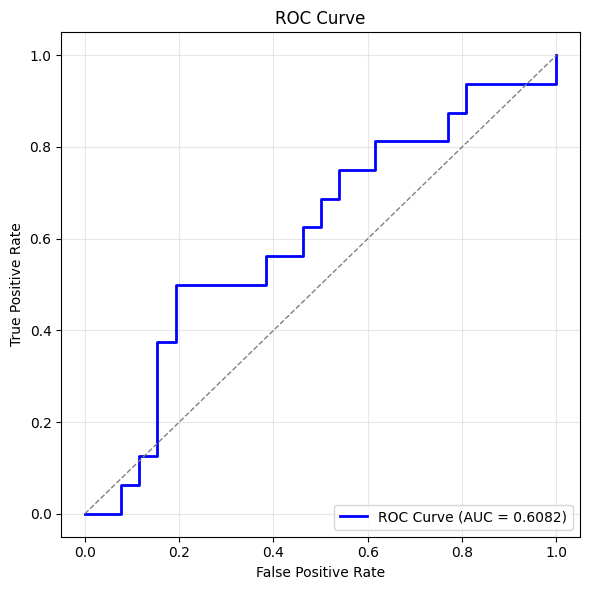

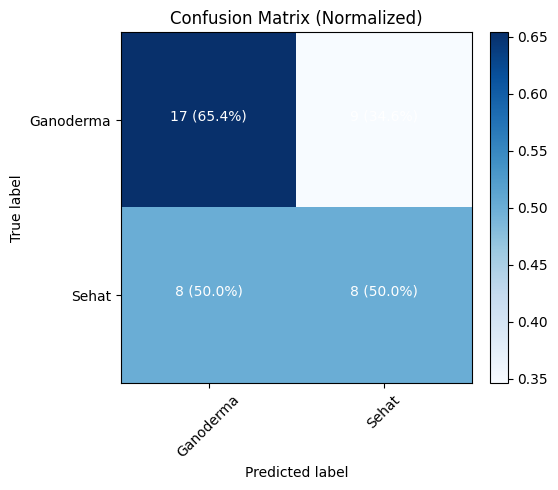

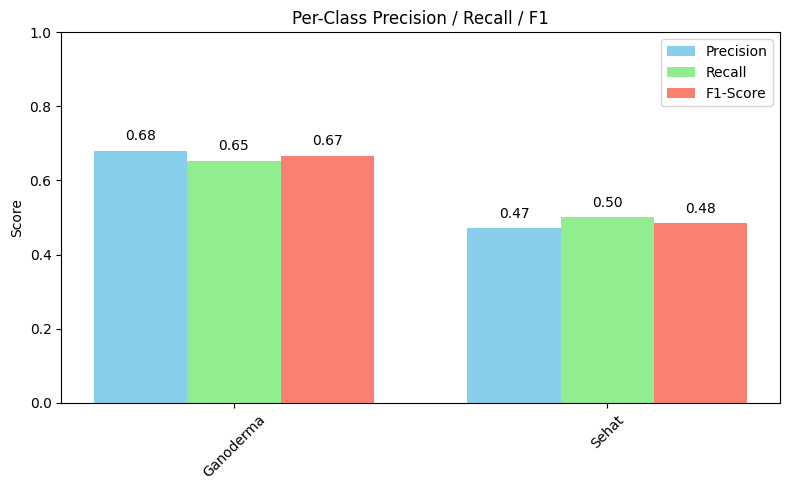

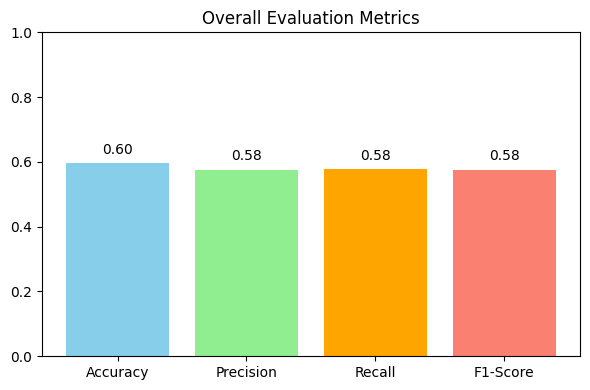

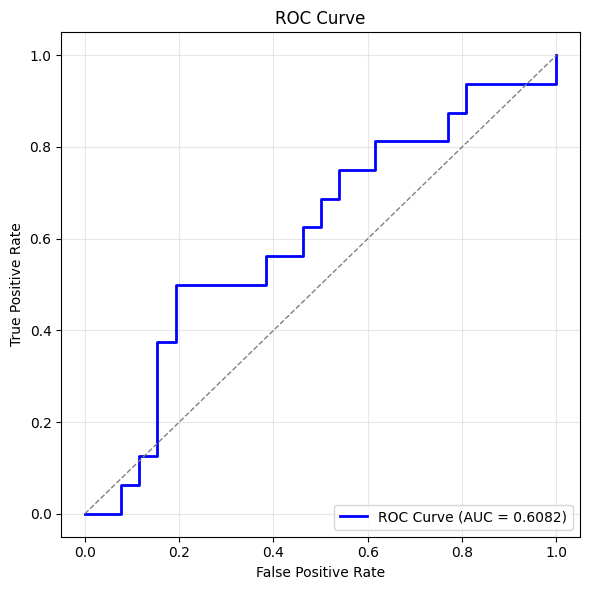

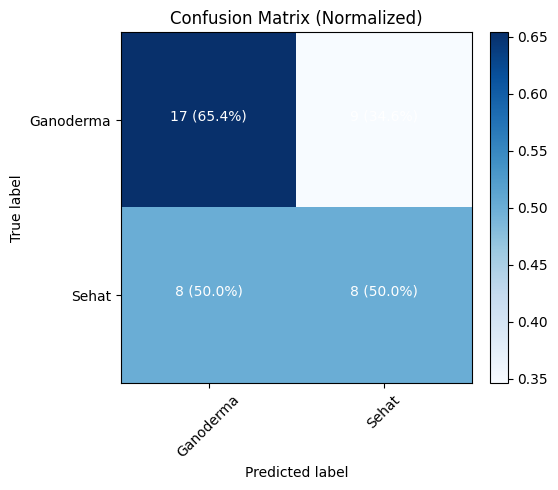

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# ======================
# ROC Curve (Binary)
# ======================
if num_classes == 2:
    y_prob_arr = np.array(y_prob)
    if y_prob_arr.ndim > 1 and y_prob_arr.shape[1] > 1:
        y_prob_pos = y_prob_arr[:, 1]
    else:
        y_prob_pos = y_prob_arr.flatten()

    fpr, tpr, _ = roc_curve(y_true, y_prob_pos, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ======================
# Confusion Matrix (Normalized)
# ======================
cm = confusion_matrix(
    y_true, y_pred, labels=list(range(len(class_names)))
)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm_norm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ======================
# Per-Class Metrics (Precision / Recall / F1)
# ======================
report = classification_report(
    y_true,
    y_pred,
    labels=list(range(len(class_names))),
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

# pastikan semua class_names ada
precisions, recalls, f1s = [], [], []
for cname in class_names:
    precisions.append(report.get(cname, {}).get('precision', 0.0))
    recalls.append(report.get(cname, {}).get('recall', 0.0))
    f1s.append(report.get(cname, {}).get('f1-score', 0.0))

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width, precisions, width, label='Precision', color='skyblue')
bars2 = plt.bar(x, recalls, width, label='Recall', color='lightgreen')
bars3 = plt.bar(x + width, f1s, width, label='F1-Score', color='salmon')

plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Per-Class Precision / Recall / F1")
plt.legend()

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                 f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ======================
# Summary Metrics (Accuracy / Precision / Recall / F1)
# ======================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

metrics = [acc, prec, rec, f1]
names = ["Accuracy", "Precision", "Recall", "F1-Score"]

plt.figure(figsize=(6, 4))
bars = plt.bar(names, metrics, color=['skyblue','lightgreen','orange','salmon'])
plt.ylim(0, 1)
plt.title("Overall Evaluation Metrics")

for bar, val in zip(bars, metrics):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02,
             f"{val:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# ======================
# ROC Curve (Binary)
# ======================
if num_classes == 2:
    y_prob_arr = np.array(y_prob)
    if y_prob_arr.ndim > 1 and y_prob_arr.shape[1] > 1:
        y_prob_pos = y_prob_arr[:, 1]
    else:
        y_prob_pos = y_prob_arr.flatten()

    fpr, tpr, _ = roc_curve(y_true, y_prob_pos, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ======================
# Confusion Matrix (Normalized)
# ======================
cm = confusion_matrix(
    y_true, y_pred, labels=list(range(len(class_names)))
)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm_norm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

